## Volatility_and ImpliedVolatility


In [1]:
# impliedVol https://t3index.com/indexes/bit-vol/

In [2]:
# get Data

In [3]:
from datetime import datetime, timedelta

startTime = datetime(2021,12,31)
sampleEndTime = datetime(2023,1,1)
endTime = datetime(2023,1,31,11, 59)
monthDays = 31

In [4]:
import pymongo
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [5]:
symbolList = ['btc_usdt.spot:binance', 'eth_usdt.spot:binance']
client = pymongo.MongoClient('172.16.20.81', 27017)

In [6]:
def readDb(collection, start, end):
    return pd.DataFrame(
        list(collection.find({"datetime": {'$gt': start, '$lt': end}}))
    )

In [7]:

dbClient = client['Kline_1Min_Auto_Db_Plus']
columnsName = ['open', 'high', 'low', 'close', 'volume','datetime']

In [8]:
crytoDict = {
                'btc':readDb(dbClient[symbolList[0]], start=startTime , end=endTime)[columnsName],
                'eth':readDb(dbClient[symbolList[1]], start=startTime , end=endTime)[columnsName]
            }

In [9]:
def resampleDf(data, freq='H'):
    dataDf = data.set_index('datetime')
    dataDuration = dataDf.resample(freq).agg({'open':'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume':'sum'})
    dataResetDf = dataDuration.reset_index()
    return dataResetDf

In [10]:
def addSymbol(dataDf, symbolName):
    dataDf['symbol'] = symbolName
    return dataDf

In [11]:
def setIndex(dataDf):
    dataIndex = dataDf.set_index(['datetime', 'symbol'])
    return dataIndex

In [12]:
multiCryptoDict = {}
for key, df in crytoDict.items():
    hourDf = resampleDf(df)
    hourSymbolDf = addSymbol(hourDf, key)
    hourIndexDf = setIndex(hourSymbolDf)
    multiCryptoDict[key] = hourIndexDf

In [13]:
multiDf = pd.concat(list(multiCryptoDict.values())).sort_index()

In [14]:
multiDf

open      high       low     close  \
datetime            symbol                                           
2021-12-31 00:00:00 btc     47193.46  47640.00  47092.13  47578.69   
                    eth      3711.39   3762.08   3705.39   3756.80   
2021-12-31 01:00:00 btc     47578.69  47770.00  47467.08  47663.51   
                    eth      3756.81   3758.85   3736.66   3741.59   
2021-12-31 02:00:00 btc     47663.50  47887.07  47474.58  47860.75   
...                              ...       ...       ...       ...   
2023-01-31 09:00:00 eth      1570.41   1574.99   1563.36   1569.99   
2023-01-31 10:00:00 btc     22830.23  22913.71  22817.30  22857.93   
                    eth      1570.00   1575.63   1569.11   1569.37   
2023-01-31 11:00:00 btc     22857.93  22869.94  22814.81  22831.82   
                    eth      1569.38   1570.67   1567.00   1568.76   

                                 volume  
datetime            symbol               
2021-12-31 00:00:00 btc      1492.84248  
                    eth     12285.87890  
2021-12-31 01:00:00 btc      1127.83834  
                    eth      7067.92760  
2021-12-31 02:00:00 btc      1145.17908  
...                                 ...  
2023-01-31 09:00:00 eth     16166.28550  
2023-01-31 10:00:00 btc      8411.65056  
                    eth     10204.64050  
2023-01-31 11:00:00 btc      5529.32016  
                    eth      7851.75860  

[19032 rows x 5 columns]

In [15]:
# daily pctChange
dailyPeriod = 24
close = multiDf.close.unstack()
pctChangeStd = close.pct_change().rolling(24).std()*((1440/60)**0.5)
sampleVol = pctChangeStd.loc[:sampleEndTime]

In [16]:
def resampleVolDf(data, freq='D'):
    dataDuration = data.resample(freq).last()
    return dataDuration

In [17]:
# histVol
btcHistVol = pctChangeStd['btc'].loc[endTime-timedelta(days=monthDays):endTime]
ethHistVol = pctChangeStd['eth'].loc[endTime-timedelta(days=monthDays):endTime]

btcWeeklyHistVol = resampleVolDf(btcHistVol)
ethWeeklyHistVol = resampleVolDf(ethHistVol)

In [18]:
from scipy.stats import percentileofscore

def roundStr(num):
    return str(round(num, 2))+'%'

btcHvCurrent = roundStr(btcWeeklyHistVol.iloc[-1]*100)
ethHvCurrent = roundStr(ethWeeklyHistVol.iloc[-1]*100)
btcHvQuantile = roundStr(percentileofscore(sampleVol['btc'], btcHistVol.iloc[-1]))
ethHvQuantile = roundStr(percentileofscore(sampleVol['eth'], ethHistVol.iloc[-1]))
btcHvMean = roundStr(btcWeeklyHistVol.mean()*100)
ethHvMean = roundStr(ethWeeklyHistVol.mean()*100)
btcHvChange = str(round((btcWeeklyHistVol.pct_change(monthDays-1)*100).iloc[-1],2))+'%'
ethHvChange = str(round((ethWeeklyHistVol.pct_change(monthDays-1)*100).iloc[-1],2))+'%'

In [19]:
histVolDf = pd.DataFrame({'BTC': [btcHvCurrent, btcHvQuantile, btcHvMean, btcHvChange], 
                "ETH": [ethHvCurrent, ethHvQuantile, ethHvMean, ethHvChange],
                 str((endTime-timedelta(days=monthDays)).date())+'~'+str(endTime.date()):['Current Historical Volatility', 'Current Historical Volatility Quantile', 'Monthly Mean of Historical Volatility', 'Monthly Pct_Change of Historical Volatility']}
                )

In [20]:
histVolDf

,BTC,ETH,2022-12-31~2023-01-31
0,2.62%,2.97%,Current Historical Volatility
1,50.94%,35.63%,Current Historical Volatility Quantile
2,1.97%,2.43%,Monthly Mean of Historical Volatility
3,503.71%,333.02%,Monthly Pct_Change of Historical Volatility


In [21]:
histVolDf = histVolDf.set_index(str((endTime-timedelta(days=monthDays)).date())+'~'+str(endTime.date()))

In [22]:
histVolDf.to_excel('histVolTable.xlsx')

In [23]:
histVolDf

,BTC,ETH
2022-12-31~2023-01-31,,
Current Historical Volatility,2.62%,2.97%
Current Historical Volatility Quantile,50.94%,35.63%
Monthly Mean of Historical Volatility,1.97%,2.43%
Monthly Pct_Change of Historical Volatility,503.71%,333.02%


In [24]:
# import requests

# url = "https://crypto-volatility-index.p.rapidapi.com/history_EOD/ETH/17-00-00"

# headers = {
# 	"X-RapidAPI-Key": "0c65b0593bmsh75c52aac35b8d95p11844fjsn3d584f3d4334",
# 	"X-RapidAPI-Host": "crypto-volatility-index.p.rapidapi.com"
# }

# response = requests.request("GET", url, headers=headers)

# print(response.text)

In [25]:
btcIvDf = pd.read_csv('bitVol.csv')
ethIvDf = pd.read_csv('ethVol.csv')

In [26]:
# btcIvDf

In [27]:
btcIvDf['datetime'] = list(map(lambda dt: datetime.strptime(dt[0][:dt[0].find(';')], '%Y-%m-%d %H:%M:%S'), btcIvDf.values))
btcIvDf['iv'] = list(map(lambda dt: float(dt[0][dt[0].find(';')+1:]), btcIvDf.values))
btcIvData = btcIvDf[['datetime', 'iv']].set_index('datetime')
btcYearlyIv = btcIvData.loc[startTime:sampleEndTime]
btcWeeklyIv = btcIvData.loc[endTime-timedelta(days=monthDays):endTime]

In [28]:
ethIvDf['datetime'] = list(map(lambda dt: datetime.strptime(dt[0][:dt[0].find(';')], '%Y-%m-%d %H:%M:%S'), ethIvDf.values))
ethIvDf['iv'] = list(map(lambda dt: float(dt[0][dt[0].find(';')+1:]), ethIvDf.values))
ethIvData = ethIvDf[['datetime', 'iv']].set_index('datetime')
ethYearlyIv = ethIvData.loc[startTime:sampleEndTime]
ethWeeklyIv = ethIvData.loc[endTime-timedelta(days=monthDays):endTime]

In [29]:
str(round(btcWeeklyIv['iv'].iloc[-1]))

'61'

In [30]:
btcIvCurrent = str(round(btcWeeklyIv['iv'].iloc[-1]))
ethIvCurrent = str(round(ethWeeklyIv['iv'].iloc[-1]))
btcIvQuantile = roundStr(percentileofscore(btcYearlyIv['iv'], btcWeeklyIv['iv'].iloc[-1]))
ethIvQuantile = roundStr(percentileofscore(ethYearlyIv['iv'], ethWeeklyIv['iv'].iloc[-1]))
btcIvMean = str(round(btcWeeklyIv['iv'].mean()))
ethIvMean = str(round(ethWeeklyIv['iv'].mean()))
btcIvChange = str(round((btcWeeklyIv['iv'].pct_change(monthDays-1)*100).iloc[-1],2))+'%'
ethIvChange = str(round((ethWeeklyIv['iv'].pct_change(monthDays-1)*100).iloc[-1],2))+'%'

In [31]:
impliedVolDf = pd.DataFrame({'BTC': [btcIvCurrent, btcIvQuantile, btcIvMean, btcIvChange], 
                "ETH": [ethIvCurrent, ethIvQuantile, ethIvMean, ethIvChange],
                str((endTime-timedelta(days=monthDays)).date())+'~'+str(endTime.date()): ['Current Implied Volatility', 'Current Implied Quantile', 'Monthly Mean of Implied Volatility', 'Monthly Pct Change of Implied Volatility']}
                )

In [32]:
impliedVolDf = impliedVolDf.set_index(str((endTime-timedelta(days=monthDays)).date())+'~'+str(endTime.date()))

In [33]:
impliedVolDf.to_excel('impliedVolTable.xlsx')

In [34]:
impliedVolDf

,BTC,ETH
2022-12-31~2023-01-31,,
Current Implied Volatility,61,69
Current Implied Quantile,9.26%,5.18%
Monthly Mean of Implied Volatility,58,69
Monthly Pct Change of Implied Volatility,22.31%,5.55%


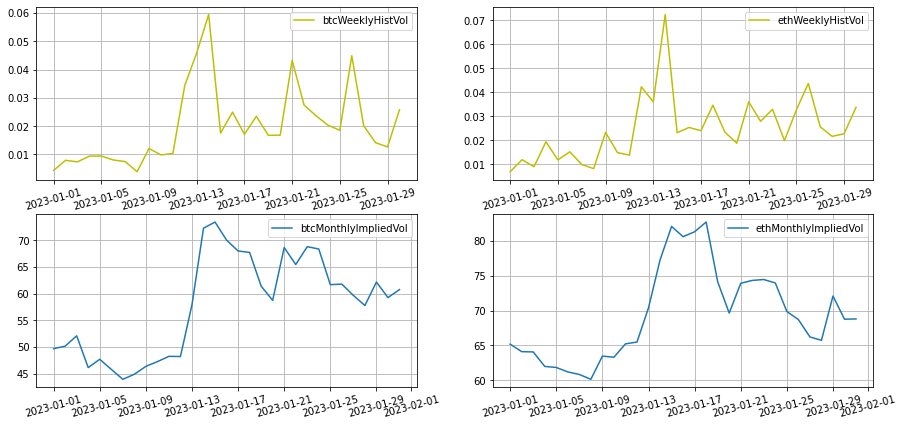

In [70]:
#plot 1:
plt.figure(figsize=(15, 7))
plt.subplot(2, 2, 1)
plt.plot(btcWeeklyHistVol.loc[endTime-timedelta(days=monthDays):endTime-timedelta(days=1)], label='btcWeeklyHistVol', color='y')
plt.legend()
plt.grid()
plt.xticks(rotation=15)


#plot 2:
plt.subplot(2, 2, 2)
plt.plot(ethWeeklyHistVol.loc[endTime-timedelta(days=monthDays):endTime-timedelta(days=1)], label='ethWeeklyHistVol', color='y')
plt.legend()
plt.grid()
plt.xticks(rotation=15)

plt.subplot(2, 2, 3)
plt.plot(btcWeeklyIv, label='btcMonthlyImpliedVol')
plt.legend()
plt.grid()
plt.xticks(rotation=15)

#plot 4:
plt.subplot(2, 2, 4)
plt.plot(ethWeeklyIv, label='ethMonthlyImpliedVol')
plt.legend()
plt.grid()
plt.xticks(rotation=15)
plt.savefig('weeklyVol')
plt.show()

In [79]:
sampleVol['btc'].quantile(0.2)

0.016739334955424262

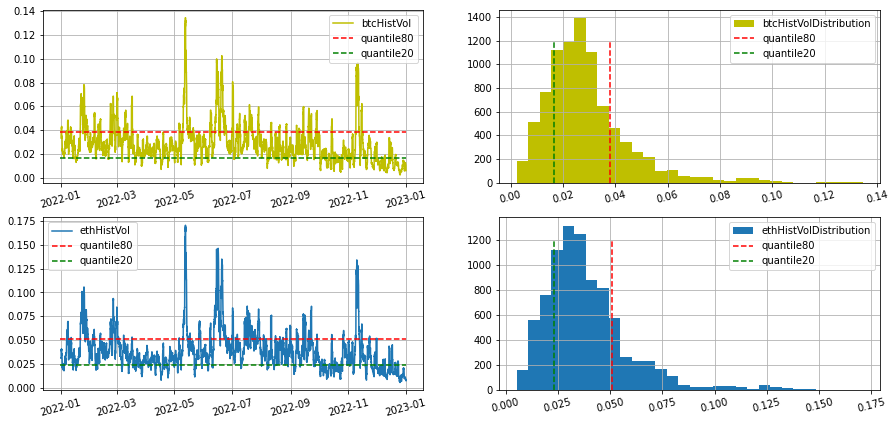

In [69]:
#plot 1:
plt.figure(figsize=(15, 7))
plt.subplot(2, 2, 1)
plt.plot(sampleVol['btc'], label='btcHistVol', color='y')
plt.hlines(sampleVol['btc'].quantile(0.8),sampleVol['btc'].index[0],sampleVol['btc'].index[-1] , color='r', linestyles='dashed', alpha=1, label='quantile80')
plt.hlines(sampleVol['btc'].quantile(0.2),sampleVol['btc'].index[0],sampleVol['btc'].index[-1] , color='g', linestyles='dashed', alpha=1, label='quantile20')
plt.legend()
plt.grid()
plt.xticks(rotation=15)

#plot 2:
plt.subplot(2, 2, 2)
plt.hist(sampleVol['btc'], label='btcHistVolDistribution', color='y', bins=30)
plt.vlines([sampleVol['btc'].quantile(0.8)], 0, 1200, linestyles='dashed'
           , alpha=1, color='r', label='quantile80')
plt.vlines([sampleVol['btc'].quantile(0.2)], 0, 1200, linestyles='dashed'
           , alpha=1, color='g', label='quantile20')
plt.legend()
plt.grid()
plt.xticks(rotation=15)

plt.subplot(2, 2, 3)
plt.plot(sampleVol['eth'], label='ethHistVol')
plt.hlines(sampleVol['eth'].quantile(0.8),sampleVol['eth'].index[0],sampleVol['eth'].index[-1] , color='r', linestyles='dashed', alpha=1, label='quantile80')
plt.hlines(sampleVol['eth'].quantile(0.2),sampleVol['eth'].index[0],sampleVol['eth'].index[-1] , color='g', linestyles='dashed', alpha=1, label='quantile20')
plt.legend()
plt.grid()
plt.xticks(rotation=15)

#plot 4:
plt.subplot(2, 2, 4)
plt.hist(sampleVol['eth'], label='ethHistVolDistribution', bins=30)
plt.vlines([sampleVol['eth'].quantile(0.8)], 0, 1200, linestyles='dashed'
           , alpha=1, color='r', label='quantile80')
plt.vlines([sampleVol['eth'].quantile(0.2)], 0, 1200, linestyles='dashed'
           , alpha=1, color='g', label='quantile20')
plt.legend()
plt.xticks(rotation=15)
plt.grid()
plt.savefig('histVolDistribution')
plt.show()


In [37]:
hvDf = round(pd.concat([sampleVol['btc'].describe(), sampleVol['eth'].describe()], axis=1, keys=['btcHv', 'ethHv']), 3)

In [38]:
hvDf.to_excel('hvStatistic2022.xlsx')

In [72]:
btcIvDf = btcIvDf.set_index('datetime')

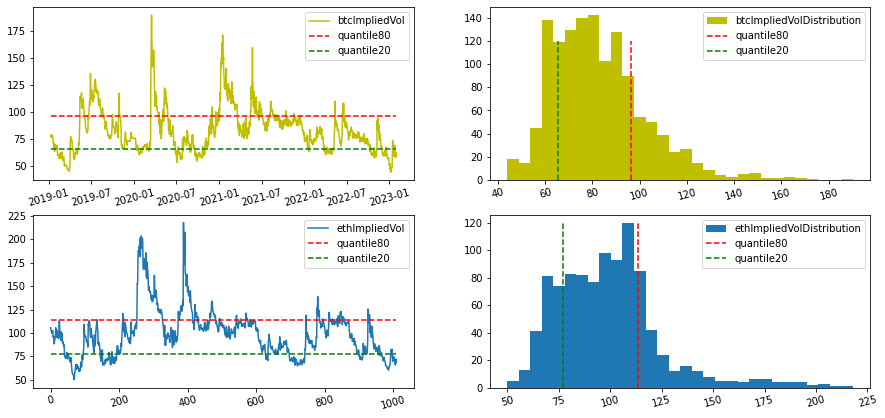

In [77]:
#plot 1:
plt.figure(figsize=(15, 7))
plt.subplot(2, 2, 1)
plt.plot(btcIvDf['iv'], label='btcImpliedVol', color='y')
plt.hlines(btcIvDf['iv'].quantile(0.8),btcIvDf['iv'].index[0],btcIvDf['iv'].index[-1] , color='r', linestyles='dashed', alpha=1, label='quantile80')
plt.hlines(btcIvDf['iv'].quantile(0.2),btcIvDf['iv'].index[0],btcIvDf['iv'].index[-1] , color='g', linestyles='dashed', alpha=1, label='quantile20')
plt.legend()
plt.xticks(rotation=15)


#plot 2:
plt.subplot(2, 2, 2)
plt.hist(btcIvDf['iv'], label='btcImpliedVolDistribution', color='y', bins=30)
plt.vlines([btcIvDf['iv'].quantile(0.8)], 0, 120, linestyles='dashed'
           , alpha=1, color='r', label='quantile80')
plt.vlines([btcIvDf['iv'].quantile(0.2)], 0, 120, linestyles='dashed'
           , alpha=1, color='g', label='quantile20')
plt.legend()
plt.xticks(rotation=15)

plt.subplot(2, 2, 3)
plt.plot(ethIvDf['iv'], label='ethImpliedVol')
plt.hlines(ethIvDf['iv'].quantile(0.8),ethIvDf['iv'].index[0],ethIvDf['iv'].index[-1] , color='r', linestyles='dashed', alpha=1, label='quantile80')
plt.hlines(ethIvDf['iv'].quantile(0.2),ethIvDf['iv'].index[0],ethIvDf['iv'].index[-1] , color='g', linestyles='dashed', alpha=1, label='quantile20')
plt.legend()
plt.xticks(rotation=15)

#plot 4:
plt.subplot(2, 2, 4)
plt.hist(ethIvDf['iv'], label='ethImpliedVolDistribution', bins=30)
plt.vlines([ethIvDf['iv'].quantile(0.8)], 0, 120, linestyles='dashed'
           , alpha=1, color='r', label='quantile80')
plt.vlines([ethIvDf['iv'].quantile(0.2)], 0, 120, linestyles='dashed'
           , alpha=1, color='g', label='quantile20')
plt.legend()
plt.xticks(rotation=15)
plt.savefig('impliedVolDistribution')
plt.show()

In [43]:
ivDf = round(pd.concat([btcIvDf['iv'].describe(), ethIvDf['iv'].describe()], axis=1, keys=['btcIv', 'ethIv']), 3)

In [41]:
ivDf.to_excel('ivStatistic2022.xlsx')